In [33]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# Now import other libraries
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

In [35]:
# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Preview the datasets
print("Customers Dataset:")
print(customers.head(), "\n")
print("Transactions Dataset:")
print(transactions.head(), "\n")


Customers Dataset:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15 

Transactions Dataset:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68   



In [37]:
# Summarize transactions by CustomerID
customer_summary = transactions.groupby("CustomerID").agg(
    {"TotalValue": "sum", "Quantity": "sum"}
).reset_index()

# Check the summary
print("Customer Summary (Transaction Aggregates):")
print(customer_summary.head())


Customer Summary (Transaction Aggregates):
  CustomerID  TotalValue  Quantity
0      C0001     3354.52        12
1      C0002     1862.74        10
2      C0003     2725.38        14
3      C0004     5354.88        23
4      C0005     2034.24         7


In [39]:
# Merge the summarized data with the customer profile
customer_data = pd.merge(customers, customer_summary, on="CustomerID", how="left")

# Fill missing values with 0 
customer_data.fillna(0, inplace=True)

# Preview the merged dataset
print("Combined Customer Data:")
print(customer_data.head())


Combined Customer Data:
  CustomerID        CustomerName         Region  SignupDate  TotalValue  \
0      C0001    Lawrence Carroll  South America  2022-07-10     3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13     1862.74   
2      C0003      Michael Rivera  South America  2024-03-07     2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09     5354.88   
4      C0005         Laura Weber           Asia  2022-08-15     2034.24   

   Quantity  
0      12.0  
1      10.0  
2      14.0  
3      23.0  
4       7.0  


In [41]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Drop irrelevant columns (like CustomerName, SignupDate)
columns_to_drop = ["CustomerID", "CustomerName", "SignupDate"]
numeric_columns = ["TotalValue", "Quantity"]

# Separate numerical and categorical columns
categorical_columns = ["Region"] 

# Apply one-hot encoding for categorical columns and scale numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_columns),  # Scale numeric features
        ("cat", OneHotEncoder(drop="first"), categorical_columns),  
    ]
)

# Fit and transform the data
processed_features = preprocessor.fit_transform(customer_data)

# Check the resulting shape
print("Shape of Processed Features:", processed_features.shape)



Shape of Processed Features: (200, 5)


In [45]:
# Choose the number of clusters
optimal_clusters = 6  #can adjust this value as needed (between 2-10 as specified)

import os
os.environ["OMP_NUM_THREADS"] = "1" #in order to resolve warning that occured

# Initialize and fit the KMeans model
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add the cluster labels to the original dataset
customer_data["Cluster"] = clusters

# Preview the dataset with cluster labels
print(customer_data.head())
print("Clustering completed without warnings.")


  CustomerID        CustomerName         Region  SignupDate  TotalValue  \
0      C0001    Lawrence Carroll  South America  2022-07-10     3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13     1862.74   
2      C0003      Michael Rivera  South America  2024-03-07     2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09     5354.88   
4      C0005         Laura Weber           Asia  2022-08-15     2034.24   

   Quantity  Cluster  
0      12.0        1  
1      10.0        5  
2      14.0        1  
3      23.0        0  
4       7.0        5  
Clustering completed without warnings.


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [49]:

#to resolve the warning and to control thread locally use threadpoolctl
from threadpoolctl import threadpool_limits

with threadpool_limits(limits=1):  # Limit threads to 1 for this block
    kmeans = KMeans(n_clusters=6, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)

# Add the cluster labels to the dataset
customer_data["Cluster"] = clusters
print("Clustering completed successfully.")



Clustering completed successfully.


In [51]:
# Preview the dataset with clusters
print("Customer Data with Clusters:")
print(customer_data.head())


Customer Data with Clusters:
  CustomerID        CustomerName         Region  SignupDate  TotalValue  \
0      C0001    Lawrence Carroll  South America  2022-07-10     3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13     1862.74   
2      C0003      Michael Rivera  South America  2024-03-07     2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09     5354.88   
4      C0005         Laura Weber           Asia  2022-08-15     2034.24   

   Quantity  Cluster  
0      12.0        1  
1      10.0        5  
2      14.0        1  
3      23.0        0  
4       7.0        5  


In [53]:
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, clusters)
print(f"Davies-Bouldin Index for {optimal_clusters} clusters: {db_index:.3f}")


Davies-Bouldin Index for 6 clusters: 1.101


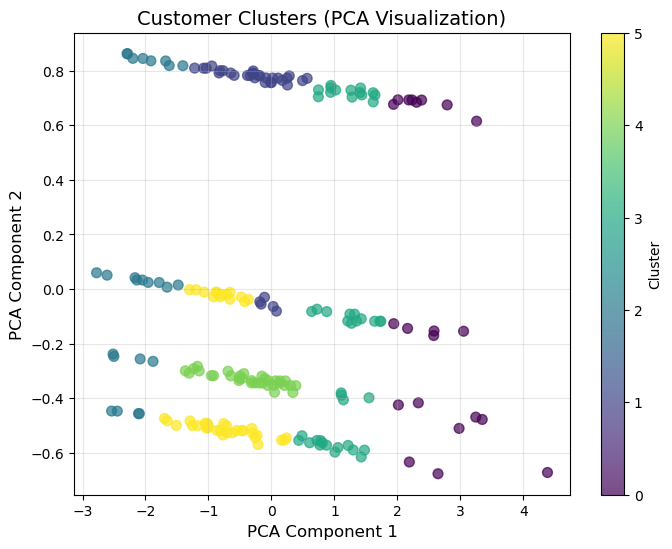

In [55]:
# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap="viridis", s=50, alpha=0.7)
plt.title("Customer Clusters (PCA Visualization)", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.colorbar(label="Cluster")
plt.grid(alpha=0.3)
plt.show()


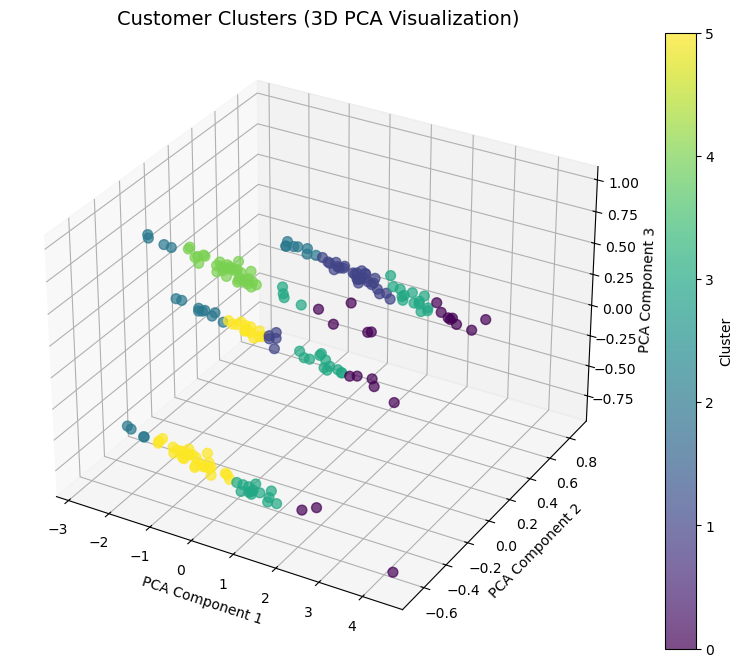

In [57]:
from mpl_toolkits.mplot3d import Axes3D

# Reduce data to 3 dimensions with PCA
pca_3d = PCA(n_components=3)
pca_results_3d = pca_3d.fit_transform(scaled_features)

# Plot clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    pca_results_3d[:, 0], pca_results_3d[:, 1], pca_results_3d[:, 2],
    c=clusters, cmap="viridis", s=50, alpha=0.7
)
ax.set_title("Customer Clusters (3D PCA Visualization)", fontsize=14)
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
plt.colorbar(scatter, ax=ax, label="Cluster")
plt.show()


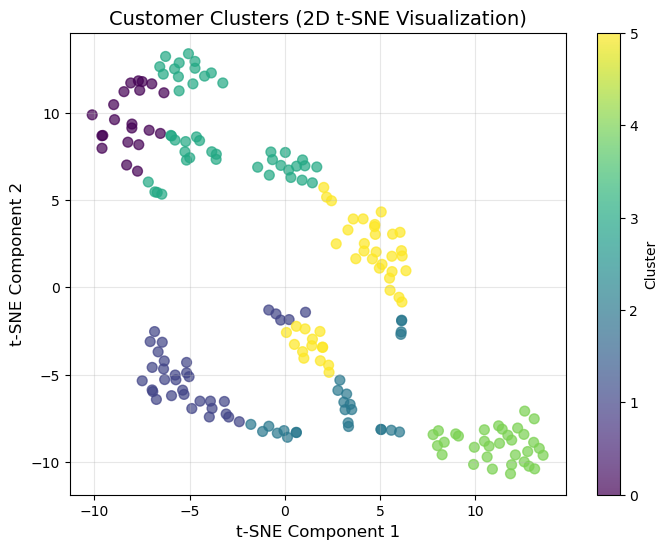

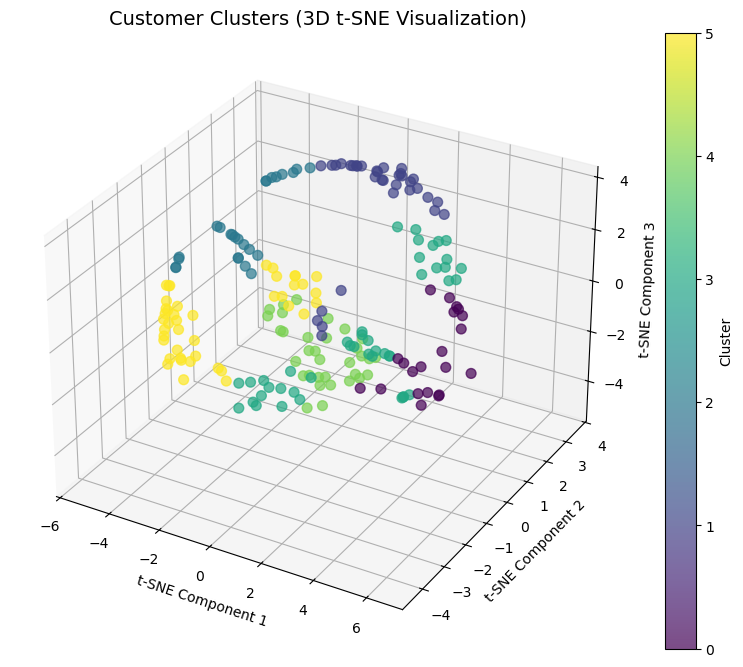

In [71]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define common t-SNE parameters
tsne_params = {
    "perplexity": 30,
    "random_state": 42,
    "max_iter": 1000
}

# 2D t-SNE
tsne_2d = TSNE(n_components=2, **tsne_params)
tsne_results_2d = tsne_2d.fit_transform(scaled_features)

# Plot 2D t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_2d[:, 0], tsne_results_2d[:, 1], c=clusters, cmap="viridis", s=50, alpha=0.7)
plt.title("Customer Clusters (2D t-SNE Visualization)", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.colorbar(label="Cluster")
plt.grid(alpha=0.3)
plt.show()

# 3D t-SNE
tsne_3d = TSNE(n_components=3, **tsne_params)
tsne_results_3d = tsne_3d.fit_transform(scaled_features)

# Plot 3D t-SNE
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    tsne_results_3d[:, 0],
    tsne_results_3d[:, 1],
    tsne_results_3d[:, 2],
    c=clusters,
    cmap="viridis",
    s=50,
    alpha=0.7
)

# Label and color the 3D plot
ax.set_title("Customer Clusters (3D t-SNE Visualization)", fontsize=14)
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_zlabel("t-SNE Component 3")
plt.colorbar(scatter, ax=ax, label="Cluster")
plt.show()


In [77]:
from threadpoolctl import threadpool_limits

optimal_clusters = 2
with threadpool_limits(limits=1):  # Limit threads to 1 for this block
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)

# Add the cluster labels to the dataset
customer_data["Cluster"] = clusters

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, clusters)
print(f"Davies-Bouldin Index for {optimal_clusters} clusters: {db_index:.3f}")



Davies-Bouldin Index for 2 clusters: 0.915


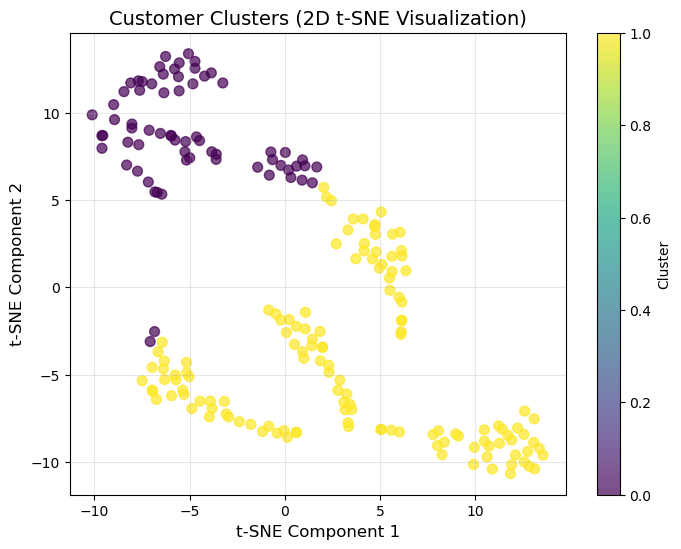

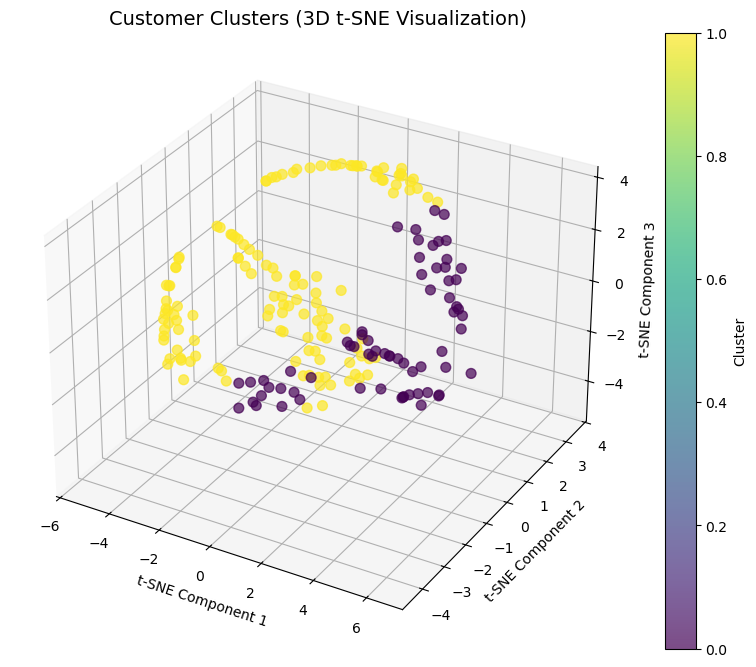

In [79]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define common t-SNE parameters
tsne_params = {
    "perplexity": 30,
    "random_state": 42,
    "max_iter": 1000
}

# 2D t-SNE
tsne_2d = TSNE(n_components=2, **tsne_params)
tsne_results_2d = tsne_2d.fit_transform(scaled_features)

# Plot 2D t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_2d[:, 0], tsne_results_2d[:, 1], c=clusters, cmap="viridis", s=50, alpha=0.7)
plt.title("Customer Clusters (2D t-SNE Visualization)", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.colorbar(label="Cluster")
plt.grid(alpha=0.3)
plt.show()

# 3D t-SNE
tsne_3d = TSNE(n_components=3, **tsne_params)
tsne_results_3d = tsne_3d.fit_transform(scaled_features)

# Plot 3D t-SNE
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    tsne_results_3d[:, 0],
    tsne_results_3d[:, 1],
    tsne_results_3d[:, 2],
    c=clusters,
    cmap="viridis",
    s=50,
    alpha=0.7
)

# Label and color the 3D plot
ax.set_title("Customer Clusters (3D t-SNE Visualization)", fontsize=14)
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_zlabel("t-SNE Component 3")
plt.colorbar(scatter, ax=ax, label="Cluster")
plt.show()


In [185]:
from threadpoolctl import threadpool_limits

#DBI for 6 clusters with increased random state 

optimal_clusters = 6
with threadpool_limits(limits=1):  # Limit threads to 1 for this block
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=9754)
    clusters = kmeans.fit_predict(scaled_features)

# Add the cluster labels to the dataset
customer_data["Cluster"] = clusters

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, clusters)
print(f"Davies-Bouldin Index for {optimal_clusters} clusters: {db_index:.3f}")



Davies-Bouldin Index for 6 clusters: 0.999


in the above for the same 6 clusters with increased random state the DBI reduced from 1.101 to 0.999 (as 0-1 is considered good clustering)

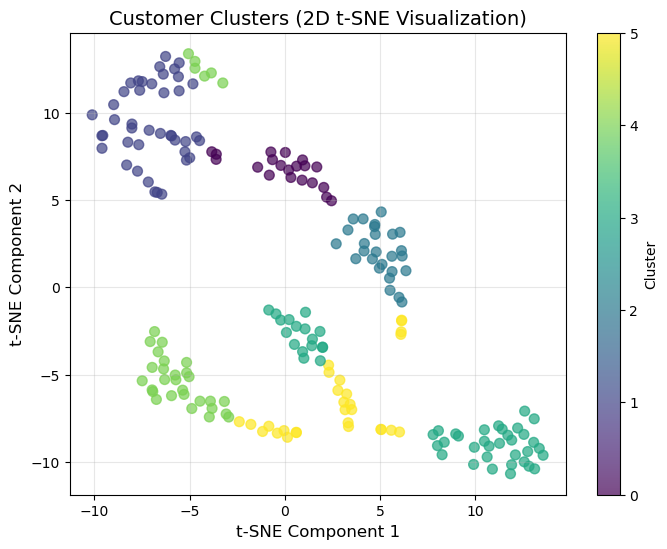

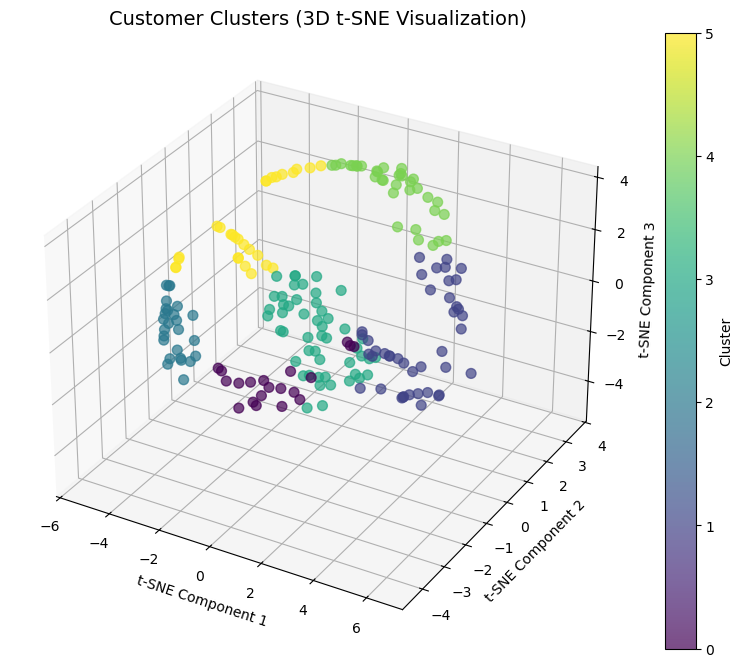

In [129]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define common t-SNE parameters
tsne_params = {
    "perplexity": 30,
    "random_state": 42,
    "max_iter": 1000
}

# 2D t-SNE
tsne_2d = TSNE(n_components=2, **tsne_params)
tsne_results_2d = tsne_2d.fit_transform(scaled_features)

# Plot 2D t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_2d[:, 0], tsne_results_2d[:, 1], c=clusters, cmap="viridis", s=50, alpha=0.7)
plt.title("Customer Clusters (2D t-SNE Visualization)", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.colorbar(label="Cluster")
plt.grid(alpha=0.3)
plt.show()

# 3D t-SNE
tsne_3d = TSNE(n_components=3, **tsne_params)
tsne_results_3d = tsne_3d.fit_transform(scaled_features)

# Plot 3D t-SNE
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    tsne_results_3d[:, 0],
    tsne_results_3d[:, 1],
    tsne_results_3d[:, 2],
    c=clusters,
    cmap="viridis",
    s=50,
    alpha=0.7
)

# Label and color the 3D plot
ax.set_title("Customer Clusters (3D t-SNE Visualization)", fontsize=14)
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_zlabel("t-SNE Component 3")
plt.colorbar(scatter, ax=ax, label="Cluster")
plt.show()


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge data on CustomerID (example, adjust as needed)
data = pd.merge(customers, transactions, on='CustomerID')

# Preprocess the data (select features you want to use for clustering)
# Example: Assuming 'age', 'income', 'spending_score' are columns you want to use
features = data[['age', 'income', 'spending_score']]

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Experiment with eps and min_samples
labels = dbscan.fit_predict(scaled_data)

# Metrics
db_index = davies_bouldin_score(scaled_data, labels)
silhouette = silhouette_score(scaled_data, labels)

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:, 1], hue=labels, palette='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1 (e.g., Age)')
plt.ylabel('Feature 2 (e.g., Income)')
plt.show()

# Print results
print(f'Number of clusters: {len(set(labels)) - (1 if -1 in labels else 0)}')
print(f'Davies-Bouldin Index: {db_index}')
print(f'Silhouette Score: {silhouette}')


In [157]:
# Import DBSCAN from sklearn
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score

# Apply DBSCAN for clustering
dbscan = DBSCAN(eps=0.5, min_samples=20)

# Fit DBSCAN and predict the clusters
dbscan_clusters = dbscan.fit_predict(processed_features)

# Add the DBSCAN cluster labels to the dataset
customer_data["DBSCAN_Cluster"] = dbscan_clusters
print("DBSCAN Clustering completed successfully.")

# Preview the dataset with DBSCAN clusters
print("Customer Data with DBSCAN Clusters:")
print(customer_data.head())



DBSCAN Clustering completed successfully.
Customer Data with DBSCAN Clusters:
  CustomerID        CustomerName         Region  SignupDate  TotalValue  \
0      C0001    Lawrence Carroll  South America  2022-07-10     3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13     1862.74   
2      C0003      Michael Rivera  South America  2024-03-07     2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09     5354.88   
4      C0005         Laura Weber           Asia  2022-08-15     2034.24   

   Quantity  Cluster  DBSCAN_Cluster  
0      12.0        4              -1  
1      10.0        3              -1  
2      14.0        4              -1  
3      23.0        1              -1  
4       7.0        5              -1  


In [159]:
# Exclude noise points (label -1 in DBSCAN)
valid_dbscan_clusters = dbscan_clusters[dbscan_clusters != -1]
valid_processed_features = processed_features[dbscan_clusters != -1]

# Ensure there are valid clusters before calculating DBI
if len(valid_dbscan_clusters) > 0:
    dbi = davies_bouldin_score(valid_processed_features, valid_dbscan_clusters)
    print(f'Davies-Bouldin Index for DBSCAN Clustering: {round(dbi, 3)}')
else:
    print("No valid clusters found after DBSCAN.")


No valid clusters found after DBSCAN.


In [179]:
# Apply DBSCAN for clustering
# Set the parameters for DBSCAN: eps (neighborhood radius) and min_samples (minimum samples per cluster)
dbscan = DBSCAN(eps=0.5, min_samples=15)

# Fit DBSCAN and predict the clusters
dbscan_clusters = dbscan.fit_predict(processed_features)

# Add the DBSCAN cluster labels to the dataset
customer_data["DBSCAN_Cluster"] = dbscan_clusters
print("DBSCAN Clustering completed successfully.")

# Preview the dataset with DBSCAN clusters
print("Customer Data with DBSCAN Clusters:")
print(customer_data.head())


DBSCAN Clustering completed successfully.
Customer Data with DBSCAN Clusters:
  CustomerID        CustomerName         Region  SignupDate  TotalValue  \
0      C0001    Lawrence Carroll  South America  2022-07-10     3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13     1862.74   
2      C0003      Michael Rivera  South America  2024-03-07     2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09     5354.88   
4      C0005         Laura Weber           Asia  2022-08-15     2034.24   

   Quantity  Cluster  DBSCAN_Cluster  
0      12.0        4               0  
1      10.0        3              -1  
2      14.0        4               0  
3      23.0        1              -1  
4       7.0        5              -1  


In [181]:
# Calculate Davies-Bouldin Index (DBI) for the clustering
# We exclude noise points (label -1 in DBSCAN)
valid_dbscan_clusters = dbscan_clusters[dbscan_clusters != -1]
processed_features_valid = processed_features[dbscan_clusters != -1]

dbi = davies_bouldin_score(processed_features_valid, valid_dbscan_clusters)
print(f'Davies-Bouldin Index for DBSCAN Clustering: {dbi:.3f}')


Davies-Bouldin Index for DBSCAN Clustering: 0.513


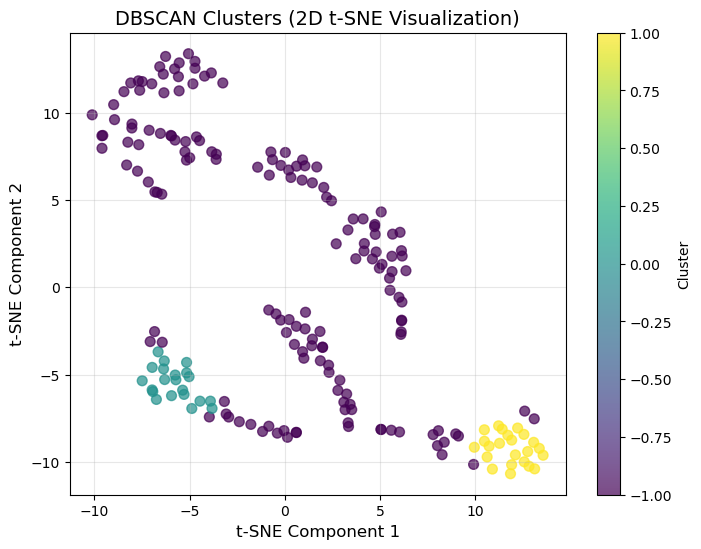

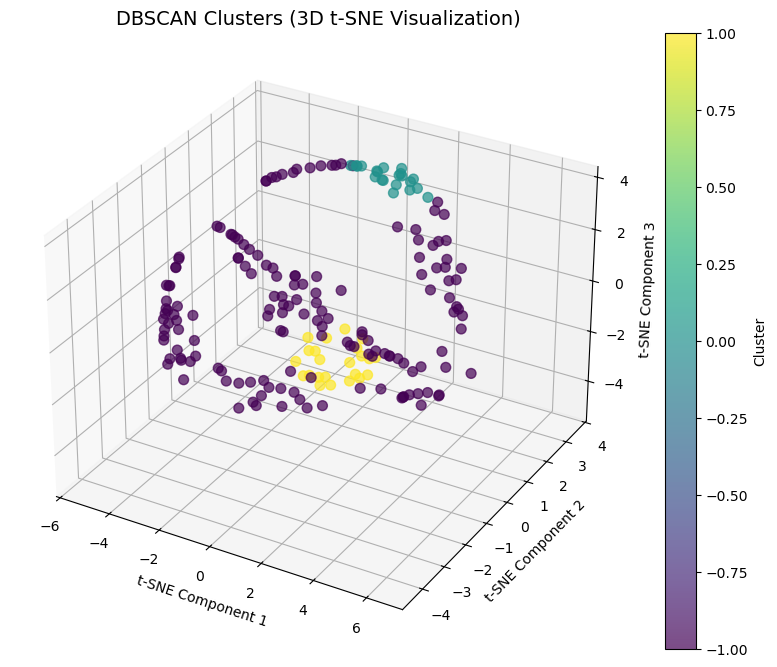

In [183]:
# 2D t-SNE for DBSCAN
tsne_2d_dbscan = TSNE(n_components=2, **tsne_params)
tsne_results_2d_dbscan = tsne_2d_dbscan.fit_transform(processed_features)

# Plot the DBSCAN clusters
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_2d_dbscan[:, 0], tsne_results_2d_dbscan[:, 1], c=dbscan_clusters, cmap="viridis", s=50, alpha=0.7)
plt.title("DBSCAN Clusters (2D t-SNE Visualization)", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.colorbar(label="Cluster")
plt.grid(alpha=0.3)
plt.show()

# 3D t-SNE for DBSCAN
tsne_3d_dbscan = TSNE(n_components=3, **tsne_params)
tsne_results_3d_dbscan = tsne_3d_dbscan.fit_transform(processed_features)

# Plot the 3D DBSCAN clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    tsne_results_3d_dbscan[:, 0],
    tsne_results_3d_dbscan[:, 1],
    tsne_results_3d_dbscan[:, 2],
    c=dbscan_clusters,
    cmap="viridis",
    s=50,
    alpha=0.7
)

ax.set_title("DBSCAN Clusters (3D t-SNE Visualization)", fontsize=14)
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_zlabel("t-SNE Component 3")
plt.colorbar(scatter, ax=ax, label="Cluster")
plt.show()


In [217]:
# Apply DBSCAN for clustering
dbscan = DBSCAN(eps=0.5, min_samples=13, metric='manhattan')
dbscan_clusters = dbscan.fit_predict(processed_features)

customer_data["DBSCAN_Cluster"] = dbscan_clusters

valid_dbscan_clusters = dbscan_clusters[dbscan_clusters != -1]
processed_features_valid = processed_features[dbscan_clusters != -1]

dbi = davies_bouldin_score(processed_features_valid, valid_dbscan_clusters)
print(f'Davies-Bouldin Index for DBSCAN Clustering: {dbi:.3f}')


Davies-Bouldin Index for DBSCAN Clustering: 0.342


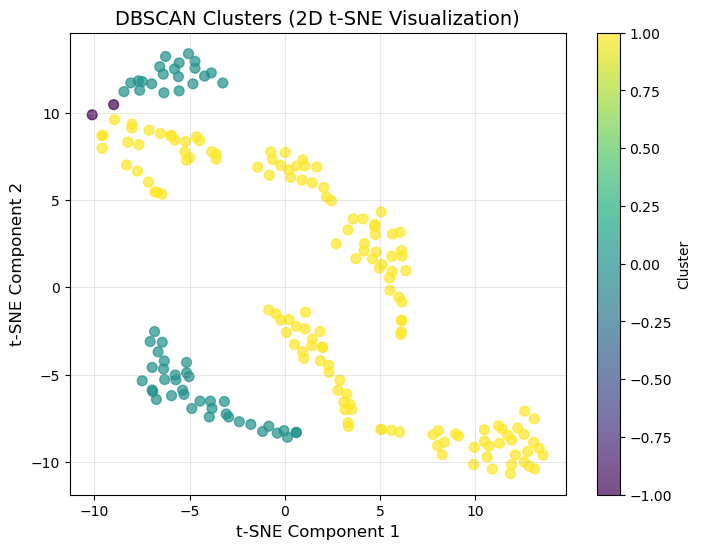

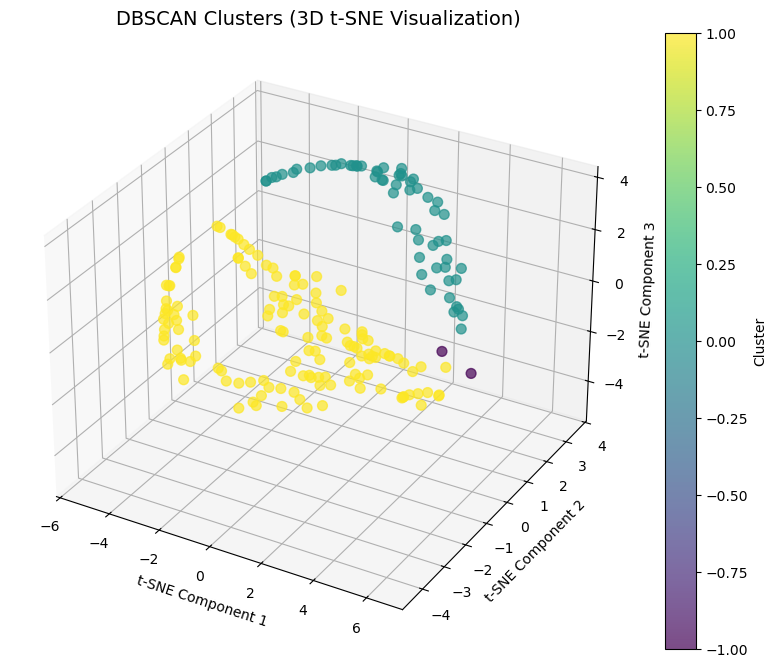

In [221]:
# 2D t-SNE for DBSCAN
tsne_2d_dbscan = TSNE(n_components=2, **tsne_params)
tsne_results_2d_dbscan = tsne_2d_dbscan.fit_transform(processed_features)

# Plot the DBSCAN clusters
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_2d_dbscan[:, 0], tsne_results_2d_dbscan[:, 1], c=dbscan_clusters, cmap="viridis", s=50, alpha=0.7)
plt.title("DBSCAN Clusters (2D t-SNE Visualization)", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.colorbar(label="Cluster")
plt.grid(alpha=0.3)
plt.show()

# 3D t-SNE for DBSCAN
tsne_3d_dbscan = TSNE(n_components=3, **tsne_params)
tsne_results_3d_dbscan = tsne_3d_dbscan.fit_transform(processed_features)

# Plot the 3D DBSCAN clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    tsne_results_3d_dbscan[:, 0],
    tsne_results_3d_dbscan[:, 1],
    tsne_results_3d_dbscan[:, 2],
    c=dbscan_clusters,
    cmap="viridis",
    s=50,
    alpha=0.7
)

ax.set_title("DBSCAN Clusters (3D t-SNE Visualization)", fontsize=14)
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_zlabel("t-SNE Component 3")
plt.colorbar(scatter, ax=ax, label="Cluster")
plt.show()


Davies-Bouldin Index for Agglomerative Clustering: 1.025


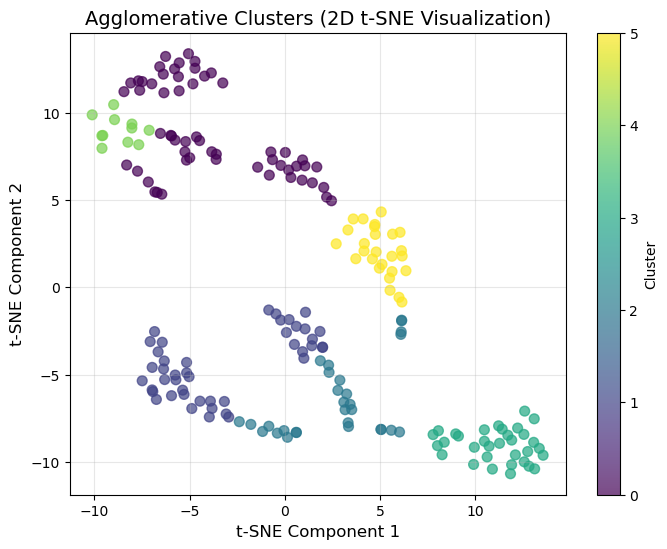

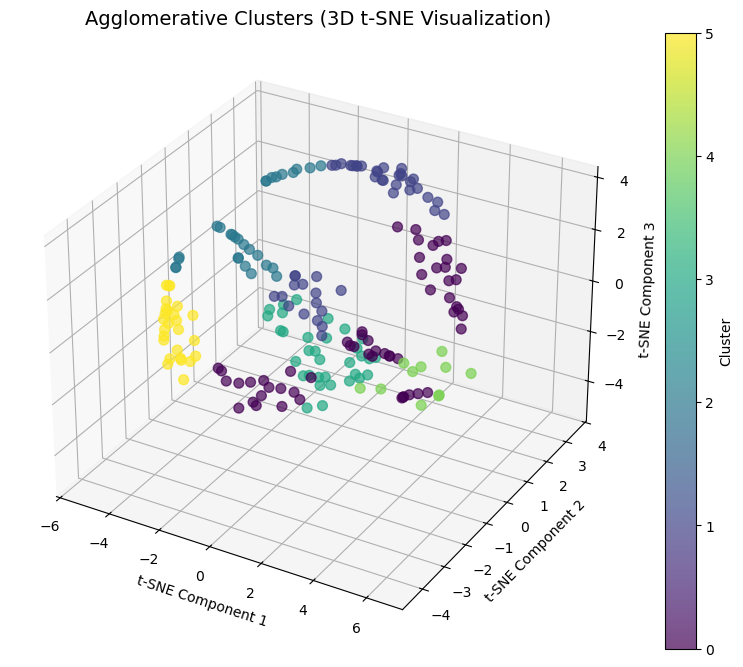

In [225]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Apply Agglomerative Clustering
agglo_clustering = AgglomerativeClustering(n_clusters=6, metric="euclidean", linkage="ward")
agglo_clusters = agglo_clustering.fit_predict(processed_features)

# Add the cluster labels to the dataset
customer_data["Agglo_Cluster"] = agglo_clusters

# Calculate the Davies-Bouldin Index (DBI)
dbi_agglo = davies_bouldin_score(processed_features, agglo_clusters)
print(f"Davies-Bouldin Index for Agglomerative Clustering: {dbi_agglo:.3f}")

# 2D Visualization using t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_2d[:, 0], tsne_results_2d[:, 1], c=agglo_clusters, cmap="viridis", s=50, alpha=0.7)
plt.title("Agglomerative Clusters (2D t-SNE Visualization)", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.colorbar(label="Cluster")
plt.grid(alpha=0.3)
plt.show()

# 3D Visualization using t-SNE
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    tsne_results_3d[:, 0],
    tsne_results_3d[:, 1],
    tsne_results_3d[:, 2],
    c=agglo_clusters,
    cmap="viridis",
    s=50,
    alpha=0.7,
)

ax.set_title("Agglomerative Clusters (3D t-SNE Visualization)", fontsize=14)
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_zlabel("t-SNE Component 3")
plt.colorbar(scatter, ax=ax, label="Cluster")
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin Index for GMM Clustering: 1.161


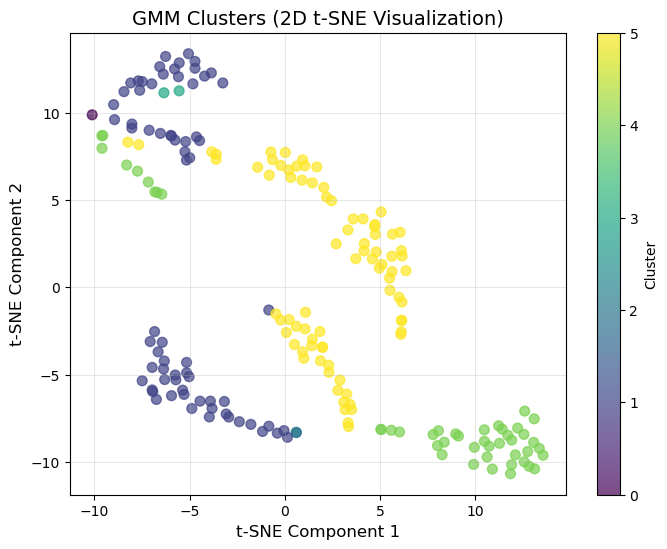

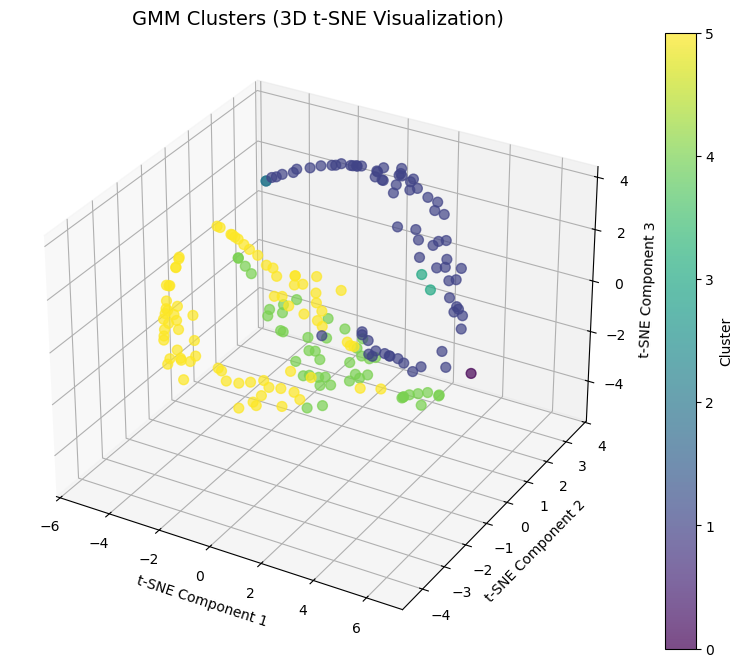

In [227]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Apply Gaussian Mixture Model Clustering
gmm = GaussianMixture(n_components=6, random_state=42)
gmm_clusters = gmm.fit_predict(processed_features)

# Add the cluster labels to the dataset
customer_data["GMM_Cluster"] = gmm_clusters

# Calculate Davies-Bouldin Index (DBI) for GMM clustering
dbi_gmm = davies_bouldin_score(processed_features, gmm_clusters)
print(f"Davies-Bouldin Index for GMM Clustering: {dbi_gmm:.3f}")

# 2D Visualization using t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_2d[:, 0], tsne_results_2d[:, 1], c=gmm_clusters, cmap="viridis", s=50, alpha=0.7)
plt.title("GMM Clusters (2D t-SNE Visualization)", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.colorbar(label="Cluster")
plt.grid(alpha=0.3)
plt.show()

# 3D Visualization using t-SNE
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    tsne_results_3d[:, 0],
    tsne_results_3d[:, 1],
    tsne_results_3d[:, 2],
    c=gmm_clusters,
    cmap="viridis",
    s=50,
    alpha=0.7,
)

# Label and color the 3D plot
ax.set_title("GMM Clusters (3D t-SNE Visualization)", fontsize=14)
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_zlabel("t-SNE Component 3")
plt.colorbar(scatter, ax=ax, label="Cluster")
plt.show()


Davies-Bouldin Index for OPTICS Clustering: 0.828


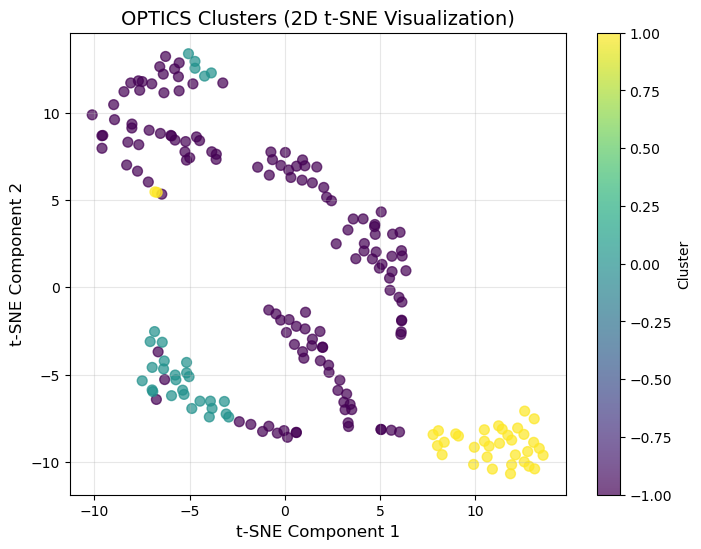

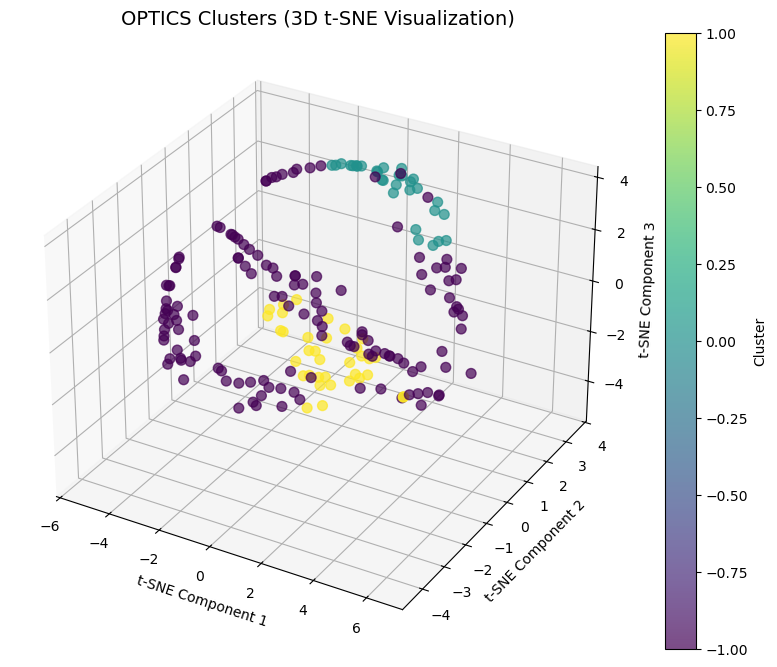

In [245]:
from sklearn.cluster import OPTICS
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Apply OPTICS clustering
optics = OPTICS(min_samples=27, min_cluster_size=0.01, metric='euclidean', cluster_method='xi', xi=0.05)
optics_clusters = optics.fit_predict(processed_features)

# Add the cluster labels to the dataset
customer_data["OPTICS_Cluster"] = optics_clusters

# Filter out noise points (-1) for DBI calculation
valid_optics_clusters = optics_clusters[optics_clusters != -1]
processed_features_valid = processed_features[optics_clusters != -1]

if len(set(valid_optics_clusters)) > 1:  # Ensure at least two clusters for DBI calculation
    dbi_optics = davies_bouldin_score(processed_features_valid, valid_optics_clusters)
    print(f"Davies-Bouldin Index for OPTICS Clustering: {dbi_optics:.3f}")
else:
    print("Davies-Bouldin Index not calculated: Less than two clusters found.")

# 2D Visualization using t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_2d[:, 0], tsne_results_2d[:, 1], c=optics_clusters, cmap="viridis", s=50, alpha=0.7)
plt.title("OPTICS Clusters (2D t-SNE Visualization)", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.colorbar(label="Cluster")
plt.grid(alpha=0.3)
plt.show()

# 3D Visualization using t-SNE
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    tsne_results_3d[:, 0],
    tsne_results_3d[:, 1],
    tsne_results_3d[:, 2],
    c=optics_clusters,
    cmap="viridis",
    s=50,
    alpha=0.7,
)

# Label and color the 3D plot
ax.set_title("OPTICS Clusters (3D t-SNE Visualization)", fontsize=14)
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_zlabel("t-SNE Component 3")
plt.colorbar(scatter, ax=ax, label="Cluster")
plt.show()
